In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 45397141.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


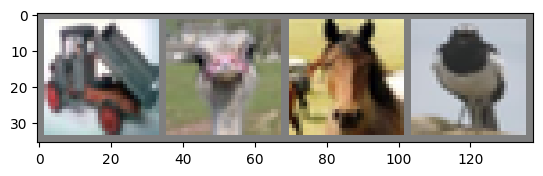

In [22]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

tensor(-1.)

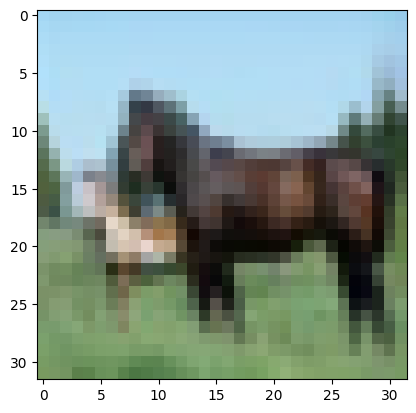

In [41]:
plt.imshow(np.transpose( train_dataset[12][0].numpy()/2+0.5, (1,2,0)))

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 input channel(color)=3, output channel =6, kernel =5, 
        self.pool = nn.MaxPool2d(2, 2)  # kernel size =2, stride =2
        self.conv2 = nn.Conv2d(6, 16, 5) # intput = 6, output =16, kernel=5
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # input=,  output 
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x


In [6]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
t1= time.perf_counter()

In [7]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')

Epoch [1/5], Step [2000/12500], Loss: 2.3057
Epoch [1/5], Step [4000/12500], Loss: 2.2791
Epoch [1/5], Step [6000/12500], Loss: 2.2770
Epoch [1/5], Step [8000/12500], Loss: 2.1969
Epoch [1/5], Step [10000/12500], Loss: 2.3931
Epoch [1/5], Step [12000/12500], Loss: 2.3366
Epoch [2/5], Step [2000/12500], Loss: 1.5419
Epoch [2/5], Step [4000/12500], Loss: 1.8166
Epoch [2/5], Step [6000/12500], Loss: 1.4988
Epoch [2/5], Step [8000/12500], Loss: 1.6872
Epoch [2/5], Step [10000/12500], Loss: 1.5697
Epoch [2/5], Step [12000/12500], Loss: 1.7303
Epoch [3/5], Step [2000/12500], Loss: 1.2261
Epoch [3/5], Step [4000/12500], Loss: 1.5441
Epoch [3/5], Step [6000/12500], Loss: 1.4486
Epoch [3/5], Step [8000/12500], Loss: 1.6320
Epoch [3/5], Step [10000/12500], Loss: 1.2534
Epoch [3/5], Step [12000/12500], Loss: 1.6070
Epoch [4/5], Step [2000/12500], Loss: 1.3004
Epoch [4/5], Step [4000/12500], Loss: 1.6311
Epoch [4/5], Step [6000/12500], Loss: 1.3392
Epoch [4/5], Step [8000/12500], Loss: 2.5254
Epoc

In [8]:
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

In [9]:

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')
t2=time.perf_counter()

print(f"time elapsted: {(t2-t1)/60.}")

Accuracy of the network: 48.76 %
Accuracy of plane: 45.4 %
Accuracy of car: 70.0 %
Accuracy of bird: 12.5 %
Accuracy of cat: 24.2 %
Accuracy of deer: 40.1 %
Accuracy of dog: 47.0 %
Accuracy of frog: 71.7 %
Accuracy of horse: 57.7 %
Accuracy of ship: 62.5 %
Accuracy of truck: 56.5 %
time elapsted: 0.9257368097999764


In [20]:
a, b = torch.max(model(test_dataset[0][0].to(device)), dim=1).indices 

tensor([3], device='cuda:0')

In [16]:
a,b

(tensor([2.4062], device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([3], device='cuda:0'))